# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [112]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

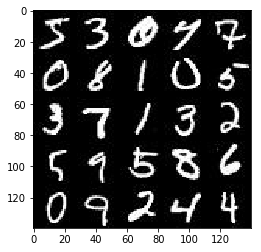

In [132]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

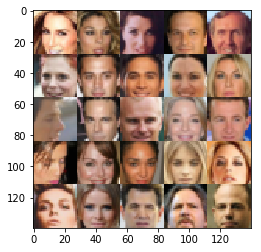

In [133]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [134]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Users\Visitor\Anaconda4\envs\face-generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [135]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='lr')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Visitor\\Anaconda4\\envs\\face-generation\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Visitor\\Anaconda4\\envs\\face-generation\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Visitor\\Anaconda4\\envs\\face-generation\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Visitor\\Anaconda4\\envs\\face-generation\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Visitor\\Anaconda4\\envs\\face-generation\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in s

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [148]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #print('Start Discriminator')
    with tf.variable_scope('discriminator', reuse=reuse):
        #print('images shape: ' + str(images.get_shape()))
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.1 * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        
        #x3 = tf.layers.conv2d(bn2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print('out shape: ' + str(out.get_shape()))
        #print('logits shape: ' + str(logits.get_shape()))
    #print('Discriminator Over')
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [149]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #print('Start generator')
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        #print('x1 shape: ' + str(x1.get_shape()))
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        #print('x1 after batch norm shape: ' + str(x1.get_shape()))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        #print('x2 shape: ' + str(x2.get_shape()))
        
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #print(x3.get_shape())
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        #print(out.get_shape())
    #print('Generator Over')
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [150]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #print('Model Loss started')
    gen_output = generator(input_z, out_channel_dim)
    logits_fake, model_fake = discriminator(gen_output, reuse=False)
    logits_real, model_real = discriminator(input_real, reuse=True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(model_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(model_fake)))
    d_loss = d_loss_real + d_loss_fake
    #print()
    #print('Model Loss Over')
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [151]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #print('Start Optimizer')
    t_var = tf.trainable_variables()
    g_var = [x for x in t_var if x.name.startswith('generator')]
    d_var = [x for x in t_var if x.name.startswith('discriminator')]
    
    #print('g_loss: ' + str(g_loss))
    #print('d_loss: ' + str(d_loss))
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #print('d_loss: ' + str(d_loss))
        #print('d_var: ' + str(d_var))
        #print('g_loss: ' + str(g_loss))
        #print('g_var: ' + str(g_var))
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_var)
        #print('In Optimizer, discriminator done')
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_var)
        
    #print('Optimizer Over, generator done')
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [152]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [159]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    print_every=10
    show_every=100
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width,
                                       image_height,
                                       image_channels,
                                       z_dim)
    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images.reshape(batch_size, image_width, image_height, image_channels)
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                #Now...................
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                         "Batch {}/{}...".format(steps, batch_size))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images=30, input_z=input_z, out_channel_dim=image_channels,
                                          image_mode=data_image_mode)
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()
                    
        saver = tf.train.Saver()
        saver.save(sess, './checkpoints/generator.ckpt')
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.3720 Batch 10/256...
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 0.6417 Batch 20/256...
Epoch 1/2... Discriminator Loss: 0.3666... Generator Loss: 1.6920 Batch 30/256...
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 1.1302 Batch 40/256...
Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 2.0929 Batch 50/256...
Epoch 1/2... Discriminator Loss: 0.4101... Generator Loss: 1.4434 Batch 60/256...
Epoch 1/2... Discriminator Loss: 0.2600... Generator Loss: 2.5138 Batch 70/256...
Epoch 1/2... Discriminator Loss: 0.1254... Generator Loss: 3.2083 Batch 80/256...
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 1.9195 Batch 90/256...
Epoch 1/2... Discriminator Loss: 0.1443... Generator Loss: 2.7602 Batch 100/256...


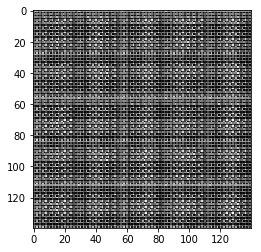

Epoch 1/2... Discriminator Loss: 0.5186... Generator Loss: 1.2170 Batch 110/256...
Epoch 1/2... Discriminator Loss: 0.3250... Generator Loss: 2.9099 Batch 120/256...
Epoch 1/2... Discriminator Loss: 0.2394... Generator Loss: 2.3566 Batch 130/256...
Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 1.0018 Batch 140/256...
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 4.4358 Batch 150/256...
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.2776 Batch 160/256...
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 3.2291 Batch 170/256...
Epoch 1/2... Discriminator Loss: 0.1350... Generator Loss: 2.5245 Batch 180/256...
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 0.7532 Batch 190/256...
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.8375 Batch 200/256...


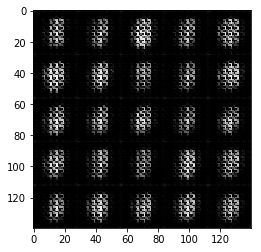

Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 1.5732 Batch 210/256...
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 2.3314 Batch 220/256...
Epoch 1/2... Discriminator Loss: 0.1958... Generator Loss: 2.8737 Batch 230/256...
Epoch 2/2... Discriminator Loss: 0.1309... Generator Loss: 2.9910 Batch 240/256...
Epoch 2/2... Discriminator Loss: 0.0526... Generator Loss: 4.4881 Batch 250/256...
Epoch 2/2... Discriminator Loss: 0.2695... Generator Loss: 1.7247 Batch 260/256...
Epoch 2/2... Discriminator Loss: 0.0828... Generator Loss: 4.6640 Batch 270/256...
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 4.3501 Batch 280/256...
Epoch 2/2... Discriminator Loss: 0.0693... Generator Loss: 3.4052 Batch 290/256...
Epoch 2/2... Discriminator Loss: 0.0957... Generator Loss: 2.8466 Batch 300/256...


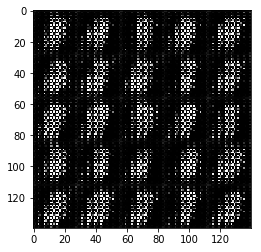

Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 3.7604 Batch 310/256...
Epoch 2/2... Discriminator Loss: 0.0876... Generator Loss: 3.7485 Batch 320/256...
Epoch 2/2... Discriminator Loss: 0.0601... Generator Loss: 3.4229 Batch 330/256...
Epoch 2/2... Discriminator Loss: 0.0359... Generator Loss: 4.1930 Batch 340/256...
Epoch 2/2... Discriminator Loss: 0.0240... Generator Loss: 4.5272 Batch 350/256...
Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 4.1047 Batch 360/256...
Epoch 2/2... Discriminator Loss: 0.3570... Generator Loss: 1.4134 Batch 370/256...
Epoch 2/2... Discriminator Loss: 0.2136... Generator Loss: 4.6297 Batch 380/256...
Epoch 2/2... Discriminator Loss: 0.1229... Generator Loss: 3.0729 Batch 390/256...
Epoch 2/2... Discriminator Loss: 0.0790... Generator Loss: 3.3716 Batch 400/256...


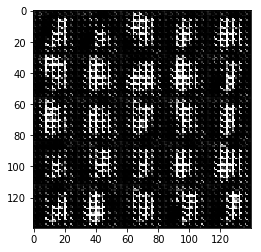

Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 1.4491 Batch 410/256...
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.3862 Batch 420/256...
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 2.2103 Batch 430/256...
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.7441 Batch 440/256...
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.5099 Batch 450/256...
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.8793 Batch 460/256...


RuntimeError: Attempted to use a closed Session.

In [160]:
batch_size = 256
z_dim = 128
learning_rate = 0.0001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 100
z_dim = 64
learning_rate = 0.001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.